In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_combined_dataset(json_path):
    """
    Reads the combined dataset JSON and returns it as a Python list of dicts.
    Each item has: { "tokens": [...], "ner_tags": [...], "intent": "..." }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [4]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return {
            'feature': torch.tensor(feature, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define Neural Network Model
class TFIDFClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TFIDFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [12]:
# Load Data
json_path = "train_test_split/train_combined.json"
data = load_combined_dataset(json_path)
texts = [" ".join(item["tokens"]) for item in data]
labels = [item["intent"] for item in data]
label_to_id = {label: idx for idx, label in enumerate(set(labels))}
labels = [label_to_id[label] for label in labels]

In [14]:
# Split Data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
train_features = tfidf_vectorizer.fit_transform(train_texts).toarray()
val_features = tfidf_vectorizer.transform(val_texts).toarray()

# Dataset and DataLoader
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize Model
input_dim = train_features.shape[1]
num_classes = len(label_to_id)
model = TFIDFClassifier(input_dim, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TFIDFClassifier(
  (fc1): Linear(in_features=809, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=22, bias=True)
)

In [15]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        features = batch['feature'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 1.2670926646774552
Epoch 2, Loss: 0.4858441370947055
Epoch 3, Loss: 0.301831657702784


In [16]:
# Validation Loop
model.eval()
val_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for batch in val_loader:
        features = batch['feature'].to(device)
        labels = batch['label'].to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}")

Validation Loss: 0.28641519392470993, Accuracy: 0.9216867469879518


In [17]:
# Ensure label alignment for classification report and confusion matrix
unique_labels = sorted(set(all_labels))
id_to_label = {v: k for k, v in label_to_id.items()}
target_names = [id_to_label[label] for label in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=target_names))

macro_f1 = f1_score(all_labels, all_predictions, average="macro")
print(f"Overall Macro F1 Score: {macro_f1:.3f}")


Classification Report:
                           precision    recall  f1-score   support

              flight_time       0.00      0.00      0.00         8
             abbreviation       0.82      0.90      0.86        20
           ground_service       0.91      0.93      0.92        42
                 aircraft       0.93      0.87      0.90        15
                 capacity       0.00      0.00      0.00         2
                     city       0.00      0.00      0.00         6
           flight+airfare       0.00      0.00      0.00         5
              ground_fare       0.00      0.00      0.00         1
aircraft+flight+flight_no       0.00      0.00      0.00         1
                flight_no       0.00      0.00      0.00         4
                  airport       0.00      0.00      0.00         3
                 quantity       0.67      0.60      0.63        10
                 distance       0.00      0.00      0.00         1
                     meal       0.00 

c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yigit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Confusion Matrix:


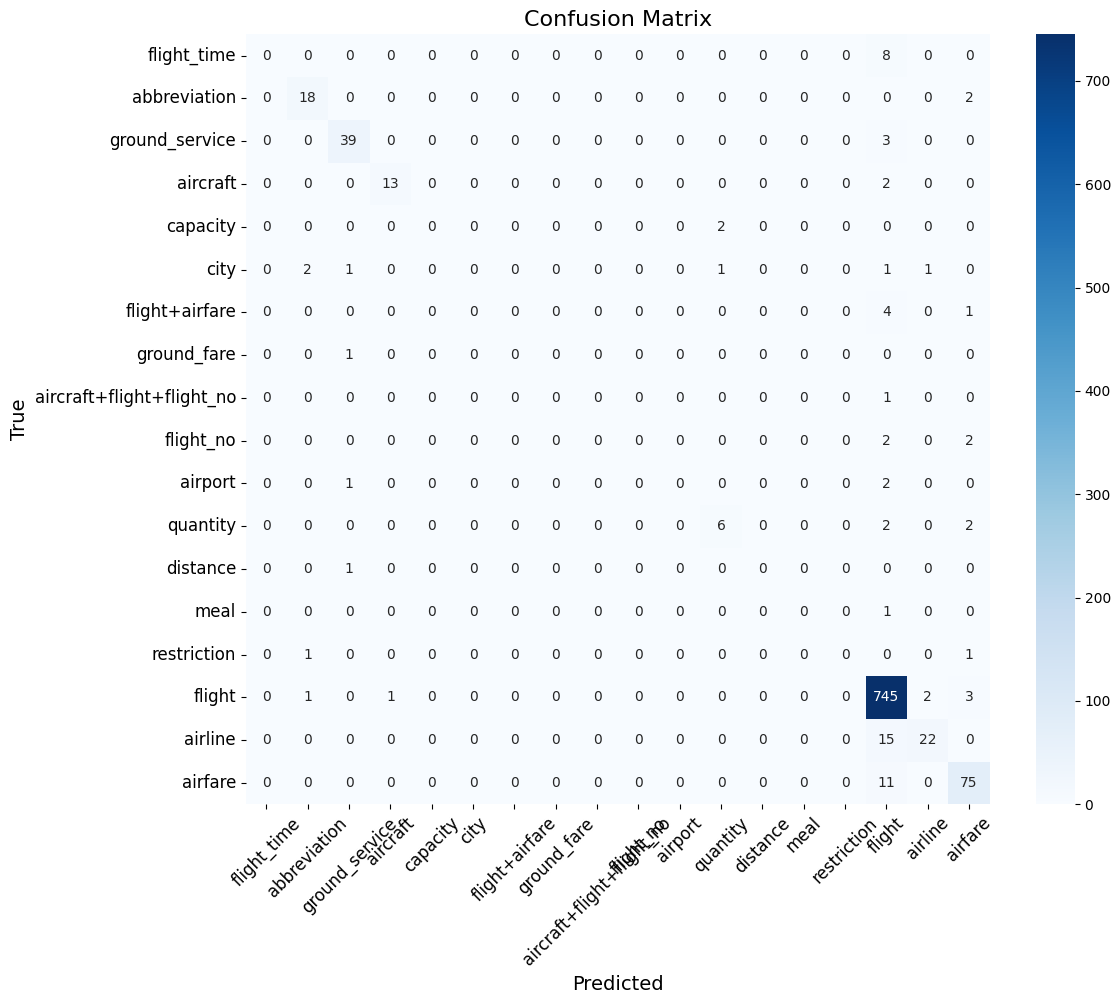

In [19]:
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()
